# Pre-Owned Car Sale Price Prediction
### This project involves developing a model to predict the appropriate selling price of a pre-owned vehicle based on several vehicle attributes.
### This is a standard `Regression Problem`.

## Data
#### The dataset used for this project was retrieved from Kaggle at : https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

**Data Features**
1. **Year** - year of manufacture.
2. **Present Price** - price of the vehicle if newly purchased from a dealership. ( In Indian Rupees (Lakhs)). Where 1 Lakh = 100,000 Rupees
3. **Kms_Driven** - the odometer in kilometers throuhgout the car's use.
4. **Fuel_Type** - type of fuel the vehicle runs on (Diesel/Petrol/CNG)
5. **Seller_Type** - mode through whcih the vehicle is being sold (Dealer/Individual)
6. **Transmission** - vehicle transmission type (Automatic/Manual)
7. **Owner** - number of previous owners.
8. **Selling_Price** - the price that the pre-owned vehicle was actually sold for. (In Indian Rupees (Lakhs)). Where 1 Lakh = 100,000 Rupees

#### In this particular case since I was prediciting selling price, the `Selling_Price` feature was the ground truth, leaving features 1-7 as the features from which the model would learn from.

## 1. Package and Library Imports

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

# Model/Estimator imports from sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# Data processing, Model evaluation and tuning tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

## 2. Loading in & Viewing the Data

In [26]:
data = pd.read_csv("data/car_data.csv")
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [27]:
len(data)

301

In [28]:
# Describing and analysing some key data statistics
data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


### 2.1 I dropped the `Car_Name` feature since it does not have much or any importance with regard to this particular investigation

In [29]:
data.drop("Car_Name", axis=1, inplace=True)
data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## 3. Data Pre-processing

In [31]:
# Checking if there are any Nan/empty elements in any of the columns
data.isna().sum()

Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

**^^There were no missing elements for any of the features**

In [32]:
# Finding out the value types within the feature data
data.dtypes

Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object

**^^ From this quick analysis I identified that :-**
* The `Fuel_Type`, `Seller_Type`, and `Transmission` features were categorical forms of data and therefore required to be trandformed/one-hot encoded into numerical data.


### 3.1 Price Data Conversion from Indian Rupees to South African Rands (ZAR)
#### Next I convert both the `Selling_Price` and `Present_Price` from Indian Rupees (100,000s) to South African Rands (100,000s)
#### 1 Indian Rupee = 0.21 South African Rands -> as of 26th March 2021
#### Therefore 100,000 Rupee = 21,000 ZAR

In [33]:
# Converting the Selling Price Column
data.Selling_Price = data.Selling_Price * 21000

# # Converting the Present Price Column
data.Present_Price = data.Present_Price * 21000

## 4. Feature Engineering

## 4.1 OneHot Encoding Categorical Data
**The `Fuel_Type`, `Seller_Type`, and `Transmission` features were categorical forms of data and therefore required to be trandformed/one-hot encoded into numerical data.**

In [34]:
#OneHotEncoding the categorical data
dummies = pd.get_dummies(data[["Fuel_Type", "Seller_Type", "Transmission"]])
dummies.head()

,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual
0,0,0,1,1,0,0,1
1,0,1,0,1,0,0,1
2,0,0,1,1,0,0,1
3,0,0,1,1,0,0,1
4,0,1,0,1,0,0,1


In [35]:
# Joining encoded data to original `data` dataframe
data = pd.concat([data, dummies], axis = 1)
Owner = data.Owner
data.drop("Owner", axis=1, inplace=True)
data = pd.concat([data, Owner], axis=1)
data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual,Owner
0,2014,70350.0,117390.0,27000,Petrol,Dealer,Manual,0,0,1,1,0,0,1,0
1,2013,99750.0,200340.0,43000,Diesel,Dealer,Manual,0,1,0,1,0,0,1,0
2,2017,152250.0,206850.0,6900,Petrol,Dealer,Manual,0,0,1,1,0,0,1,0
3,2011,59850.0,87150.0,5200,Petrol,Dealer,Manual,0,0,1,1,0,0,1,0
4,2014,96600.0,144270.0,42450,Diesel,Dealer,Manual,0,1,0,1,0,0,1,0


In [36]:
# Removing the unencoded columns from the `data` dataframe
data.drop(["Fuel_Type", "Seller_Type", "Transmission"], axis=1, inplace=True)
data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual,Owner
0,2014,70350.0,117390.0,27000,0,0,1,1,0,0,1,0
1,2013,99750.0,200340.0,43000,0,1,0,1,0,0,1,0
2,2017,152250.0,206850.0,6900,0,0,1,1,0,0,1,0
3,2011,59850.0,87150.0,5200,0,0,1,1,0,0,1,0
4,2014,96600.0,144270.0,42450,0,1,0,1,0,0,1,0


In [38]:
# Viewing the edited dataframe
data.dtypes

Year                        int64
Selling_Price             float64
Present_Price             float64
Kms_Driven                  int64
Fuel_Type_CNG               uint8
Fuel_Type_Diesel            uint8
Fuel_Type_Petrol            uint8
Seller_Type_Dealer          uint8
Seller_Type_Individual      uint8
Transmission_Automatic      uint8
Transmission_Manual         uint8
Owner                       int64
dtype: object

## 4.2 Feature Creation 
**I created a new feature -> `Age` which indicates how old the vehicle is in years**  
**It was calculated by subtracting the `Year` column from 2021.**

In [39]:
# Creating the 'Age' column
data["Current_Year"] = 2021
data["Age"] = data.Current_Year - data.Year
data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual,Owner,Current_Year,Age
0,2014,70350.0,117390.0,27000,0,0,1,1,0,0,1,0,2021,7
1,2013,99750.0,200340.0,43000,0,1,0,1,0,0,1,0,2021,8
2,2017,152250.0,206850.0,6900,0,0,1,1,0,0,1,0,2021,4
3,2011,59850.0,87150.0,5200,0,0,1,1,0,0,1,0,2021,10
4,2014,96600.0,144270.0,42450,0,1,0,1,0,0,1,0,2021,7


In [40]:
# Removing the 'Year' and 'Current_Year' columns
data.drop(["Current_Year", "Year"], axis=1, inplace=True)
data.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual,Owner,Age
0,70350.0,117390.0,27000,0,0,1,1,0,0,1,0,7
1,99750.0,200340.0,43000,0,1,0,1,0,0,1,0,8
2,152250.0,206850.0,6900,0,0,1,1,0,0,1,0,4
3,59850.0,87150.0,5200,0,0,1,1,0,0,1,0,10
4,96600.0,144270.0,42450,0,1,0,1,0,0,1,0,7


## 4.3 Data Analysis on Updated DataFrame

### Correlation Matrix

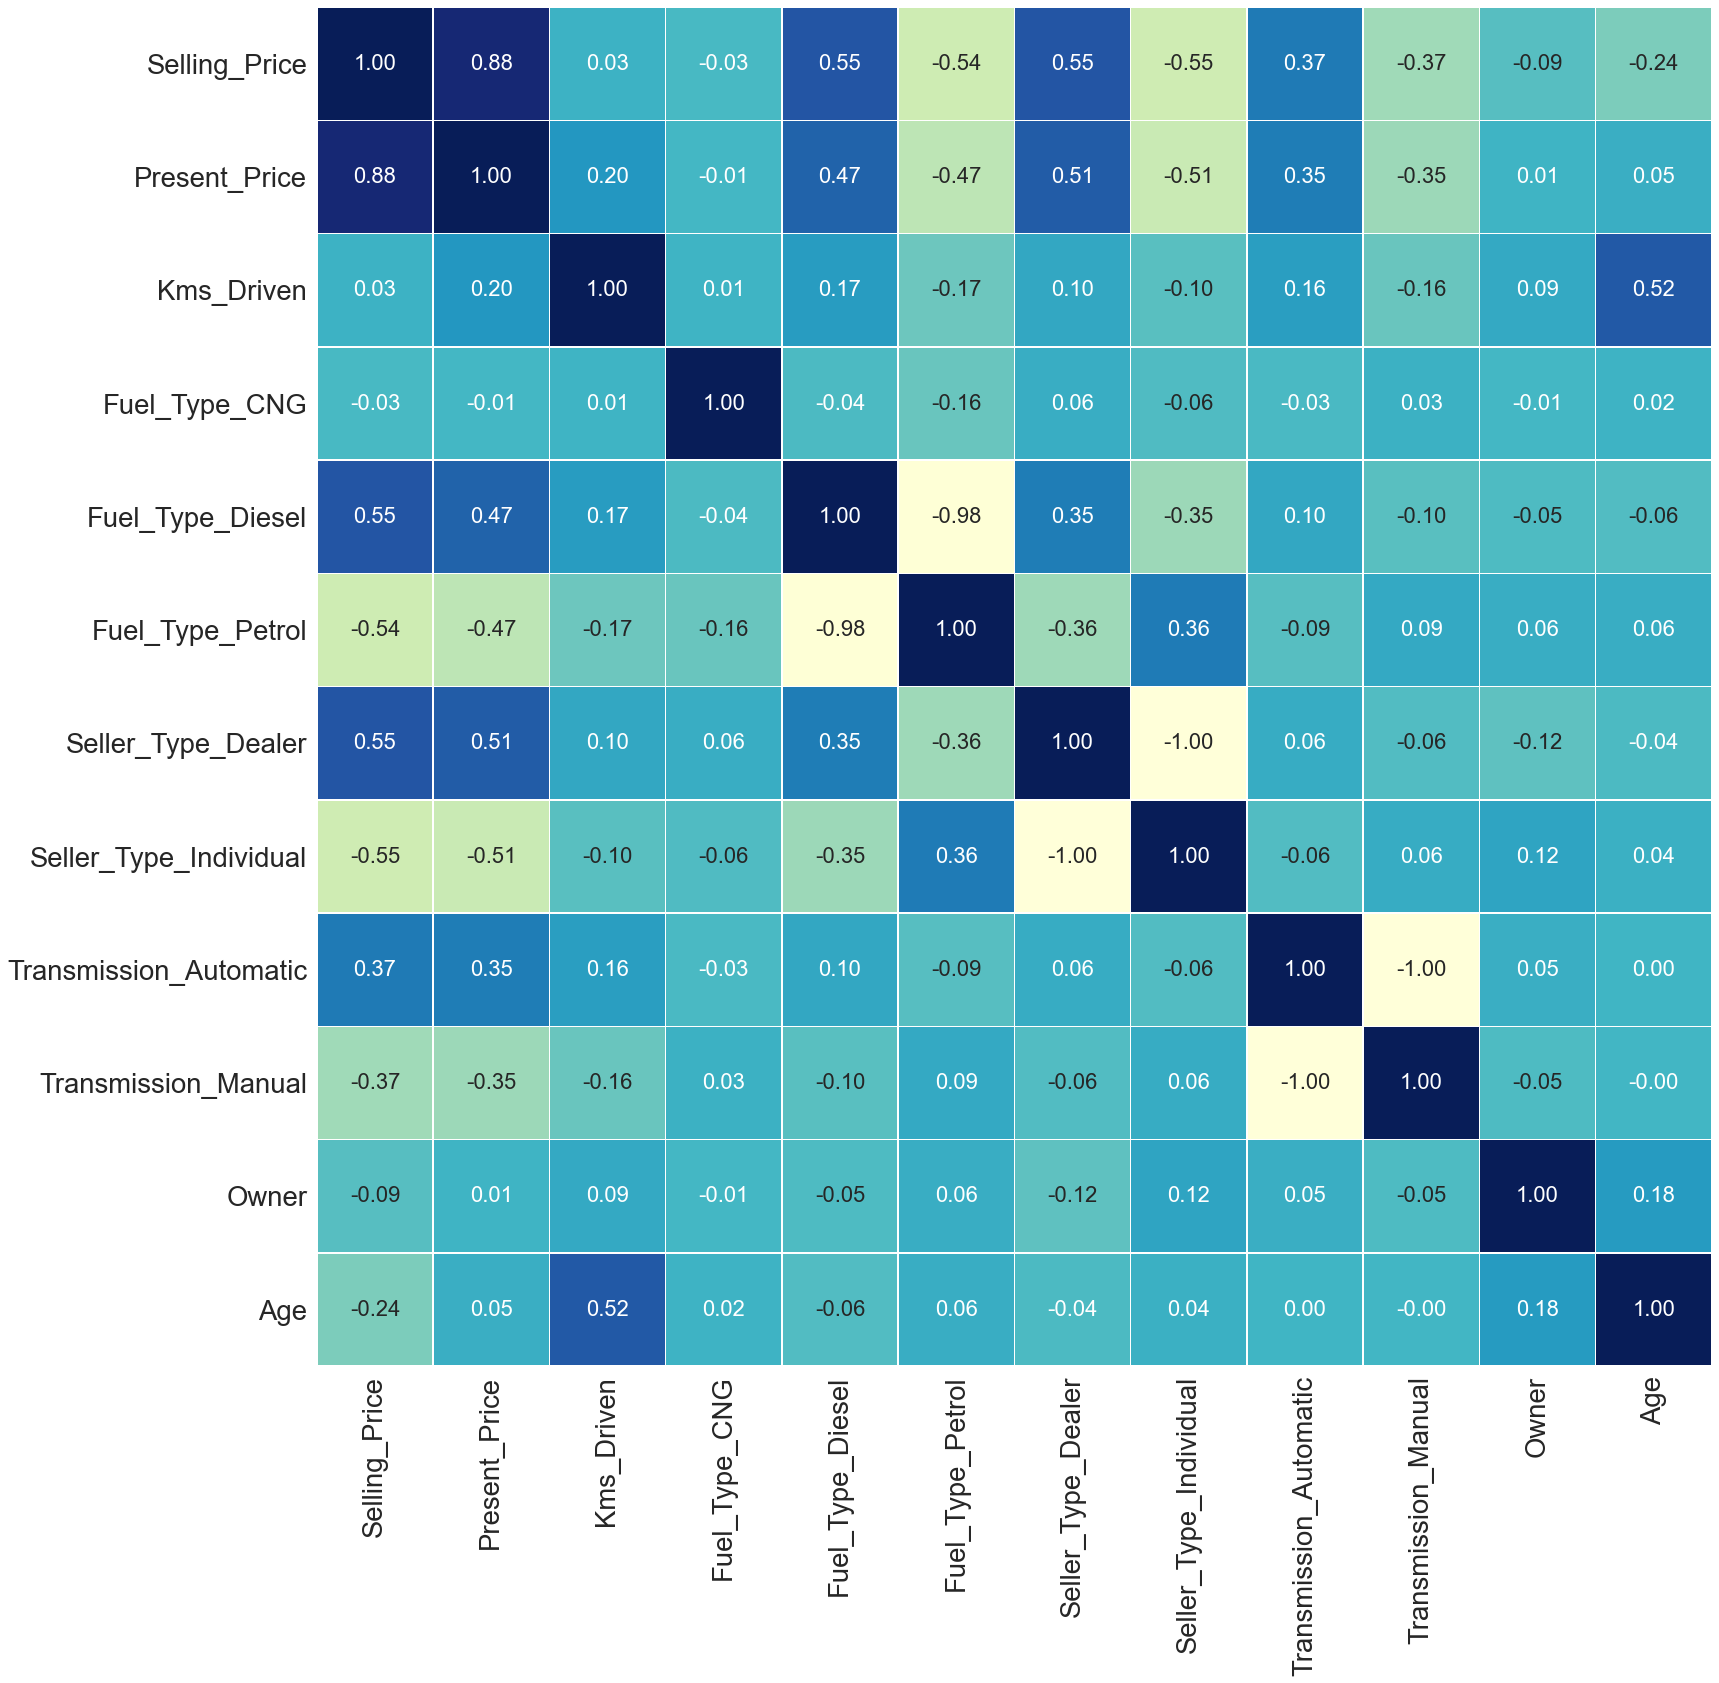

In [53]:
#Let's make our correlation matrix a little more descriptive
corr_matrix = data.corr()
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu",
                annot_kws={"size": 22},
                cbar=False);

**The Correlation Matrix reveales:**
1. The `Present_Price` has the highest positive correlation with a the `Selling Price`. This relationship is rather obvious all this thing considered -> The higher the original sale price , the higher a later re-sale price generally speaking.
2. The `Age` of the vehicle had a relatively strong negative correlation with `Selling_Price`. The older the car , the lower the re-selling price of said car.
3. A vehicle with `manual` transmission and one that was being sold by an `individual` both had a strong negative correaltion to the `Selling_Price`.
4. A `Diesel` vehicles were positively correlated with a higher selling price.

## 5. Modelling
### 5.1 Splitting data into training and testing splits

In [55]:
# Setting up random seed
np.random.seed(42)

#Creating X feature and y label data
X = data.drop("Selling_Price", axis=1)
y = data.Selling_Price

# Splitting the data into the train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### 5.2 Fitting and Evaluating Models
**Evaluation will be performed via cross validation**  

I will be comparing the baseline performance of three of the following models:
1. Linear Regression Model
2. Ridge Regression Model
3. Random Forest Regression Model
**The model with the highest R^2 score will be chosen as the project's model**

In [56]:
# Setting up random seed
np.random.seed(42)

# Creating a test summary dictionary
test_summary = {}

# Instantiating the three model objects
lin_reg = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()

#Fitting the training data on the models
lin_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rfr.fit(X_train, y_train)

#Evaluating the models using cross vaidation
lin_reg_score = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
ridge_score = cross_val_score(ridge, X, y, cv=5, scoring='r2')
rfr_score = cross_val_score(rfr, X, y, cv=5, scoring='r2')

# Updating test_summary dictionary with the cross validated MSE
test_summary['Linear Regression'] = np.mean(lin_reg_score)
test_summary['Ridge Regression'] = np.mean(ridge_score)
test_summary['Random Forest Regression'] = np.mean(rfr_score)

# Converting the test_summary dictionary into a data frame
baseline_test_results = pd.DataFrame(test_summary, index=[0])

In [57]:
# Plotting the R^2 results for the three models
baseline_test_results

,Linear Regression,Ridge Regression,Random Forest Regression
0,-18.174382,-17.998999,0.334443


### The `RandomForestRegression` model had the highest baseline R^2 score and thus was used for the rest of the project.

## 5. Improving Model/Estimator Performance
### 5.1 Improving the  `RandomForestRegression` Model's Performance


### 5.1.1 HyperParamter Tuning Using GridSearch CV

In [58]:
# Making hyperparam grid
grid = {"n_estimators": [10, 20, 100],
       "max_depth": [50, 100],
       "max_features":["auto"],
       "min_samples_leaf":[1,2,4],
       "min_samples_split":[5,10]}

# Performing grid search and cross validation to determine the best hyperparameters
rfr_grid_searched = GridSearchCV(estimator = rfr, 
                                 param_grid = grid,
                                 cv=5,
                                 verbose=2)

rfr_grid_searched.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total

[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, 

[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=100, max_

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [50, 100], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 20, 100]},
             verbose=2)

In [98]:
rfr_grid_searched.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [79]:
np.random.seed(42)

tuned_rfr = RandomForestRegressor(n_estimators = 10, max_depth=50, max_features="auto", min_samples_leaf=1, min_samples_split=5).fit(X_train, y_train)
tuned_rfr_score = np.mean(cross_val_score(tuned_rfr, X, y, cv=5, scoring='r2'))
print(tuned_rfr_score)

0.27458951996356473


### Since the baseline model has a higher R^2 score than the tuned model, The baseline model was selected

## 5.2 Using XgBoost

In [60]:
#Installing xgboost
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge xgboost

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/JJ/Desktop/MLProjects/Car_Price_Prediction/env

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    certifi-2020.12.5          |   py38h50d1736_1         143 KB  conda-forge
    libxgboost-1.1.1           |       h4a8c4bd_0         1.9 MB  conda-forge
    openssl-1.1.1k             |       h0d85af4_0         1.9 MB  conda-forge
    py-xgboost-1.1.1           |   py38h32f6830_0         1.0 MB  conda-forge
    xgboost-1.1.1              |   py38hc84c608_0          11 KB  conda-forge
    ------------------------

## 5.2 Using the `XGBRegressor` Tree-Based Model

In [61]:
# Importing xgboost
import xgboost as xg

# Instantiating the xgboost Regressor with baseline hyperparameters
xgb_reg = xg.XGBRegressor(objective = 'reg:linear')

# Fitting the model
xgb_reg.fit(X_train, y_train)

#Cross validating boosted model's baseline performance
baseline_r2_score = round(np.mean(cross_val_score(xgb_reg, X, y, cv=5, scoring='r2')), 3)
baseline_r2_score

[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj

0.395

In [62]:
# Viewing the baseline XGBReg r2 score
baseline_r2_score

0.395

### 5.2.1 Improving the Baseline `XGBRegressor's` Perfromance Using `GridSearchCV`

In [70]:
# Setting up random seed
np.random.seed(42)

# Creating hyperparam grid
xg_grid = {"n_estimators": [10, 50, 100],
          "max_depth": [3, 5, 10],
          "reg_alpha": [0, 10],
          "colsample_bytree": [0.3, 1],
          "learning_rate": [0.1, 0.3]}

# Setting up Grid SearchCV object
xgb_grid_searched = GridSearchCV(estimator = xgb_reg,
                                param_grid = xg_grid,
                                cv=5,
                                verbose=2)
# Training the GSCV xg model
xgb_grid_searched.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[14:15:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0; total time=   0.0s
[14:15:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0; total time=   0.0s
[1

[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0; total time=   0.0s
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0; total time=   0.0s
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost

[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0; total time=   0.0s
[14:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost

[14:15:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboo

[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=3, n_estimators=50, reg_alpha=0; total time=   0.0s
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=3, n_estimators=50, reg_alpha=0; total time=   0.0s
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1

[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=5, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=5, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost

[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=5, n_estimators=100, reg_alpha=10; total time=   0.0s
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=5, n_estimators=100, reg_alpha=10; total time=   0.0s
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboo

[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=10, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=10, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.3, learning_rate=0.3, max_depth=

[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10; total time=   0.0s
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_159

[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0; total time=   0.0s
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0; total time=   0.0s
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_15937

[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=10, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0; total time=   0.1s
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=10, n_e

[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_est

[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, reg_alpha=10; total time=   0.1s
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, reg_alpha=10; total time=   0.0s
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1

[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, reg_alpha=0; total time=   0.0s
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, reg_alpha=0; total time=   0.0s
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_est

[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=10, n_estimators=10, reg_alpha=10; total time=   0.0s
[14:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=10, n_estimators=50, reg_alpha=0; total time=   0.1s
[14:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=10, n_e

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosi

In [71]:
# Viewing the 'best' grid searched hyperparams
xgb_grid_searched.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0}

In [75]:
# Setting up random seed
np.random.seed(42)

# Fitting a new xgboost regressor model with the beest grid searched hyperparams
grid_searched_xgb_reg = xgb_reg = xg.XGBRegressor(objective = 'reg:linear',
                                              colsample_bytree = 1,
                                              learning_rate = 0.1,
                                              max_depth = 3,
                                              n_estimators = 100,
                                              reg_alpha = 0)
grid_searched_xgb_reg.fit(X_train, y_train)

#Evaluating r2 score
tuned_xgb_reg_score = round(np.mean(cross_val_score(grid_searched_xgb_reg, X, y, cv=5, scoring='r2')),3)
tuned_xgb_reg_score

[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/objective/regression_obj

0.12

## 5.3 Comparing and Selelcting the Final Model

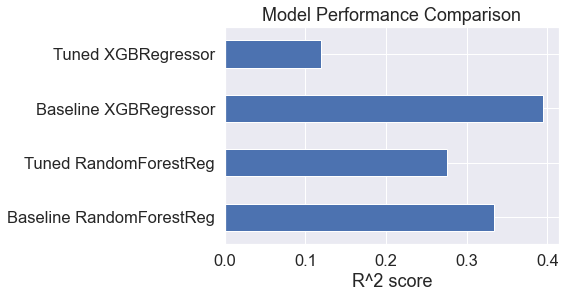

In [95]:
model_comparison = {"Baseline RandomForestReg": round(np.mean(rfr_score),3),
                   "Tuned RandomForestReg": round(tuned_rfr_score,3),
                   "Baseline XGBRegressor": baseline_r2_score,
                   "Tuned XGBRegressor": tuned_xgb_reg_score}

model_comp_df = pd.DataFrame(model_comparison, index = [0])
sns.set(font_scale =1.5)
model_comp_df.T.plot(kind='barh', title = "Model Performance Comparison", legend=False);
plt.xlabel("R^2 score");

## Model Selection Conclusion 
### The baseline `XGBRegressor` had a higher R^2 score than both its tuned version and the baseline `RandomForestRegressor`.  
### Therefore the baseline `XGBRegressor` was chosen as the project's estimator.

## 6. Evaluation Metrics

In [96]:
# Making predictions using the XBGRegressor baseline model
y_preds = xgb_reg.predict(X_test)

/Users/JJ/Desktop/MLProjects/Car_Price_Prediction/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


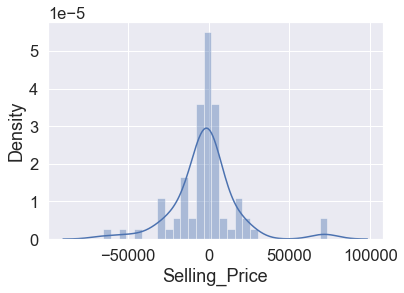

In [97]:
# Making a distplot to visualise the distribution of the error of rfr model
sns.distplot(y_test-y_preds);

### Since the distplot resembles a 'Normal Distribution' , we can conclude that the predictions made by the model are reasonably accurate.

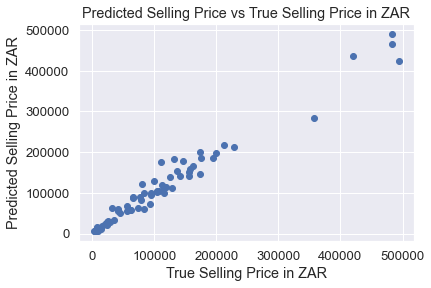

In [106]:
# Scatter plot of the y_test vs the y_preds
sns.set(font_scale = 1.2)
plt.scatter(y_test, y_preds);
plt.title("Predicted Selling Price vs True Selling Price in ZAR")
plt.xlabel("True Selling Price in ZAR")
plt.ylabel("Predicted Selling Price in ZAR");

### Since the scatter plot is linear with respect to y_test vs y_preds, we can also conclude that the predictions are reasonably accurate

## 7. Conclusive Analysis and Remarks

### Feature Importance

In [107]:
# Printing out the feature importance results
print(xgb_reg.feature_importances_)

[0.6786586  0.09680641 0.         0.04535339 0.         0.00440171
 0.         0.00344083 0.         0.         0.17133912]


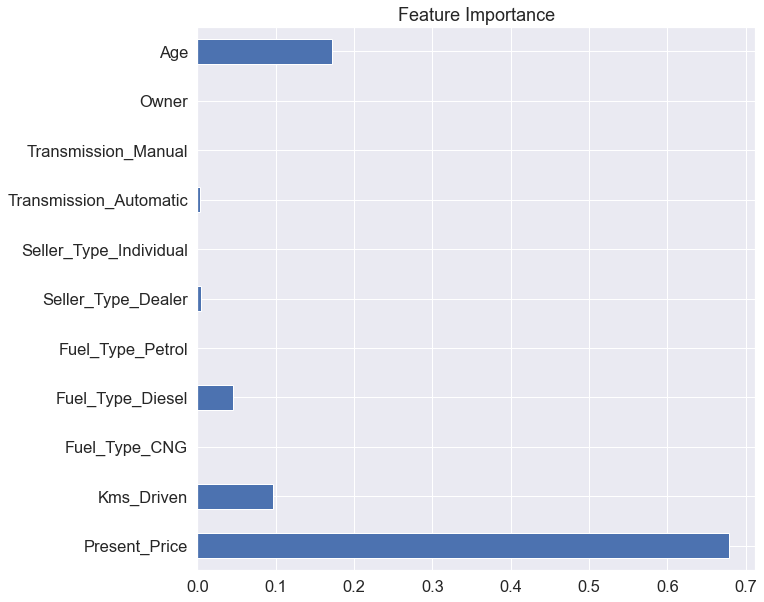

In [109]:
# Visualizing the results
feature_importance = pd.Series(xgb_reg.feature_importances_, index=X.columns)
sns.set(font_scale = 1.5)
feature_importance.plot(kind='barh', figsize=(10,10), title = 'Feature Importance')
plt.show();

### The feature importance analysis revealed:
1. The `Present_Price` (Current New Vehicle Sale Price) is the most important feature.
2. The `Age` of the vehicle eas the second most important feature.  
3. The `Kms_Driven` by the vehicle was the third most important feature.

### These findings fall right in line with the general vehicle value trends which are mainly determined by their depreciation due to their `off-the-lot price`, their `age` and `mileage`.

## Saving the Model

In [87]:
import pickle
pickle.dump(xgb_reg, open("model/xgb_reg_baseline_model.pkl", "wb"))